# Calculating ages of infection (normalized and not normalized)

## Importing libraries and paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import plotly.graph_objects as go
import matplotlib.pylab as pl

In [2]:
sys.path.append('..')

## Loading cases with ages data from Python

In [3]:
file_age = '../Data/dengue_BR_ageclasses.csv'
age_data = pd.read_csv(file_age, delimiter = ';')
age_data = age_data.dropna(axis = 0)
age_data = age_data.drop(columns = ['Unnamed: 0'])

## Age groups from TABNET and municipalities under analysis

In [4]:
age_groups = np.array([0,4,9,14,19,29,39,49,59,69,79,120]) # age groups of tabnet datasus
#municipalities = [355030,330455,520870,530010,230440,310620,354340,354980]
municipalities = [355030]

## Rate of infection for each age group over the years for all municipalities

In [5]:
def pad_missing_counts(sp_age_counts):
    ages = np.array(['(0, 4]', '(4, 9]', '(9, 14]', '(14, 19]', '(19, 29]', '(29, 39]',
       '(39, 49]', '(49, 59]', '(59, 69]', '(69, 79]', '(79, 120]'],
      dtype=object)
    years = np.arange(2007,2022,1)
    for year in years:
        for age in ages:
            filt_tmp = ((sp_age_counts['NU_ANO'] == year) & (sp_age_counts['age_range'] == age))
            if(sum(filt_tmp) == 0):
                sp_age_counts = sp_age_counts.append({'NU_ANO':year, 'age_range':age, 'CASES':0}, ignore_index=True)
    return sp_age_counts

In [6]:
def age_rates_municipality(id_municipality):
    file_sus = '../Data/Data_PopMun/TABNET/pop_pyramid_'+str(id_municipality)+'.csv'
    sus_data = pd.read_csv(file_sus, delimiter = ';')
    sus_data = sus_data[:-1] # original data
    sus_data_props = sus_data.copy() # proportion of each group/total population by year
    sus_data_tmp = sus_data_props.iloc[:,1:]
    sus_data_props.iloc[:,1:] = sus_data_tmp
    sus_props_stacked = sus_data_props.drop(columns = ['Faixa Etaria 1'])
    sus_props_stacked = sus_props_stacked.stack().reset_index(name = 'POP')
    sus_props_stacked = sus_props_stacked.sort_values(['level_1','level_0'])
    sus_props_stacked = sus_props_stacked.reset_index()
    #sus_props_stacked = sus_props_stacked.drop(21) # no data for 2008 last age group of infected
    # now we stack the total 
    total_pop = sus_data.copy()
    total_pop = total_pop.drop(columns = ['Faixa Etaria 1'])
    total_pop = total_pop.sum(axis = 0)
    total_pop = total_pop.to_frame(name = 'POP').reset_index()
    # filtering for the municipality we are working with
    sp_age_data = age_data[age_data['ID_MUNICIP'] == id_municipality] 
    # mean age of infection (without population structure) 
    sp_age_mean = sp_age_data.copy()
    sp_age_mean = sp_age_mean.groupby(['NU_ANO'])['NU_IDADE_N'].mean()
    sp_age_mean = sp_age_mean.to_frame(name = 'MEAN AGE').reset_index()
    sp_age_mean = sp_age_mean[~sp_age_mean['NU_ANO'].isin([2022])]
    # total infected in a year
    sp_cases_data = sp_age_data.copy()
    sp_cases_data = sp_cases_data.groupby(['NU_ANO'])['NU_IDADE_N'].count()
    sp_cases_data = sp_cases_data.to_frame(name = 'CASES').reset_index() #here is the error
    # rate of infection for each age group 
    sp_age_counts = sp_age_data.copy() 
    sp_age_counts = sp_age_counts.groupby(['NU_ANO','age_range'])['NU_IDADE_N'].count()
    sp_age_counts = sp_age_counts.to_frame(name = 'CASES').reset_index()
    sp_age_counts = pad_missing_counts(sp_age_counts)
    sp_age_counts['extra_sort'] = sp_age_counts['age_range'].apply(lambda st: st[st.find("(")+1:st.find(",")])
    sp_age_counts['extra_sort'] = sp_age_counts['extra_sort'].astype(int)
    sp_age_counts = sp_age_counts.sort_values(by = ['NU_ANO','extra_sort'])
    sp_age_counts = sp_age_counts.reset_index()
    sp_age_counts = sp_age_counts.drop(columns = ['index','extra_sort'])
    sp_age_counts['CASES/POP'] = sp_age_counts['CASES']/sus_props_stacked['POP']
    # adding total cases per year in this dataframe
    list_tmp = []
    for year in sp_age_counts['NU_ANO']:
        list_tmp.append(float(sp_cases_data[sp_cases_data['NU_ANO'] == year]['CASES']))
    sp_age_counts['CASES/YEAR'] = list_tmp
    return sp_age_mean, sp_age_counts

In [7]:
def plot_age_rate(sp_age_counts):
    n = len(sp_age_counts['NU_ANO'].unique())
    colors = pl.cm.jet(np.linspace(0,1,n))
    fig = plt.figure()
    i = 0
    for year in sp_age_counts['NU_ANO'].unique():
        sp_age_counts_tmp = sp_age_counts[sp_age_counts['NU_ANO'] == year]
        plt.plot(sp_age_counts_tmp['age_range'],sp_age_counts_tmp['CASES/POP'],'-o', label = year, linewidth = 2, color = colors[i])
        i = i + 1
    plt.legend(bbox_to_anchor=(1.05, 1.01))
    plt.xlabel('Age Group', fontsize = 14)
    plt.ylabel('Age Group Infection Rate', fontsize = 14)
    plt.xticks(fontsize = 12, rotation = 90)
    plt.xticks(fontsize = 12)
    plt.show()
    fig = plt.figure()
    i = 0
    for year in sp_age_counts['NU_ANO'].unique():
        sp_age_counts_tmp = sp_age_counts[sp_age_counts['NU_ANO'] == year]
        plt.plot(sp_age_counts_tmp['age_range'],sp_age_counts_tmp['CASES/POP']/sp_age_counts_tmp['CASES/YEAR'],'-o', label = year, linewidth = 2, color = colors[i])
        i = i + 1
    plt.legend(bbox_to_anchor=(1.05, 1.01))
    plt.xlabel('Age Group', fontsize = 14)
    plt.ylabel('Age Group Infection Rate (Norm)', fontsize = 14)
    plt.xticks(fontsize = 12, rotation = 90)
    plt.xticks(fontsize = 12)
    plt.show()

### Municipality 1: Sao Paulo 

C:\Users\denise.cammarota\AppData\Local\Temp\ipykernel_5084\328714551.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sp_age_counts = sp_age_counts.append({'NU_ANO':year, 'age_range':age, 'CASES':0}, ignore_index=True)


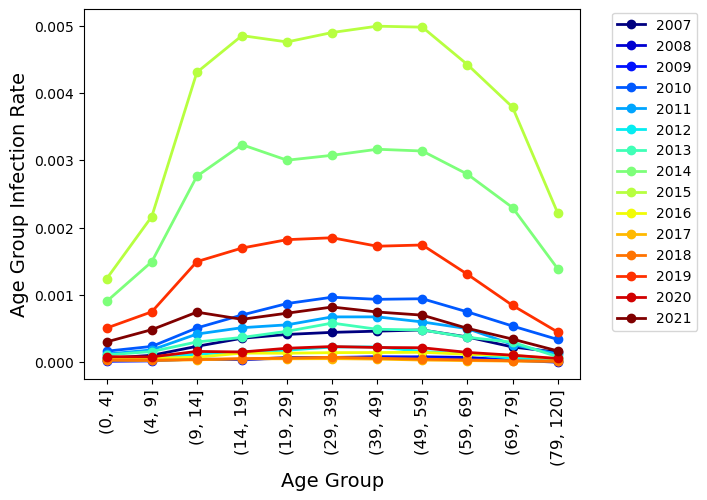

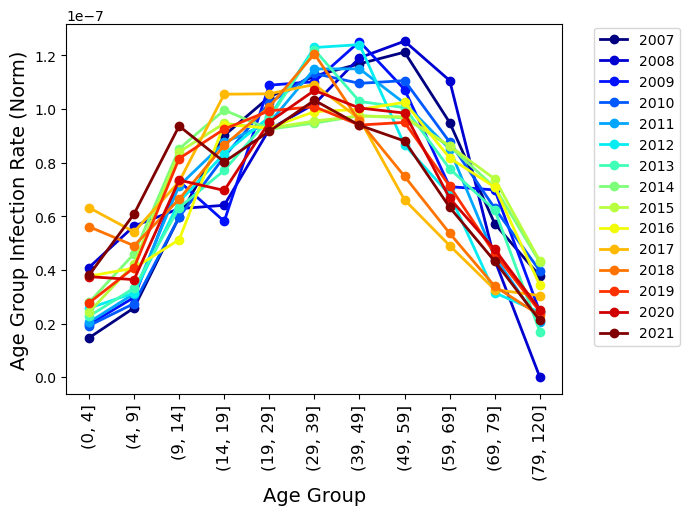

In [8]:
id_municipality = 355030
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

In [9]:
sp_age_counts

,NU_ANO,age_range,CASES,CASES/POP,CASES/YEAR
0,2007,"(0, 4]",47,0.000058,3944.0
1,2007,"(4, 9]",90,0.000102,3944.0
2,2007,"(9, 14]",203,0.000235,3944.0
3,2007,"(14, 19]",321,0.000355,3944.0
4,2007,"(19, 29]",864,0.000412,3944.0
...,...,...,...,...,...
160,2021,"(39, 49]",1375,0.000745,7935.0
161,2021,"(49, 59]",1022,0.000698,7935.0
162,2021,"(59, 69]",558,0.000502,7935.0
163,2021,"(69, 79]",212,0.000343,7935.0


### Municipality 2: Rio de Janeiro

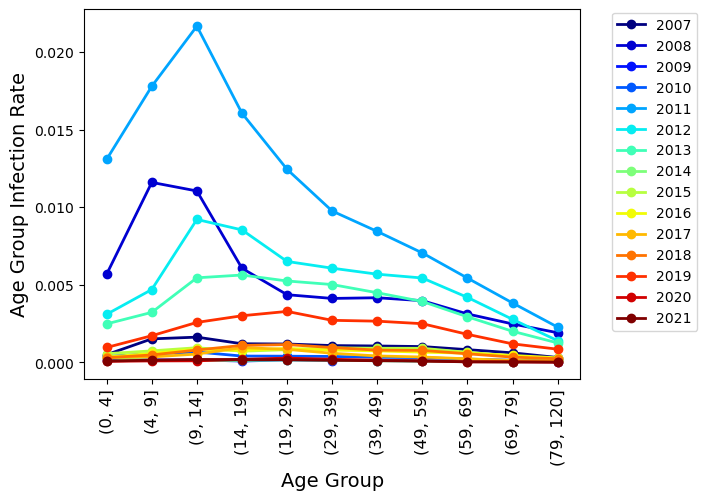

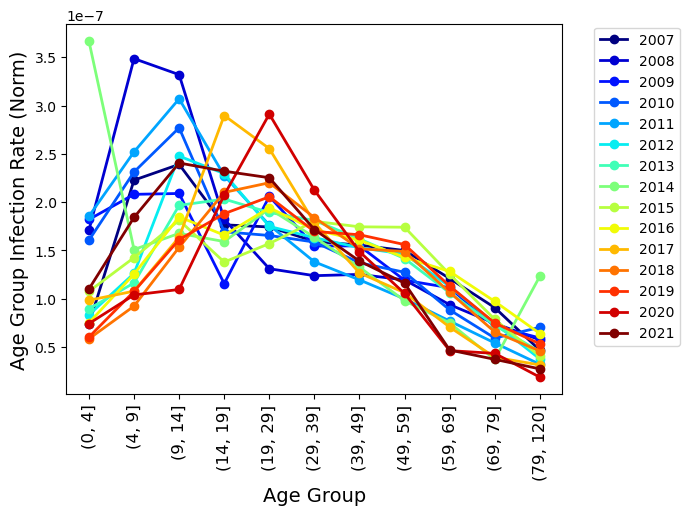

In [10]:
id_municipality = 330455
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 3: Goiania

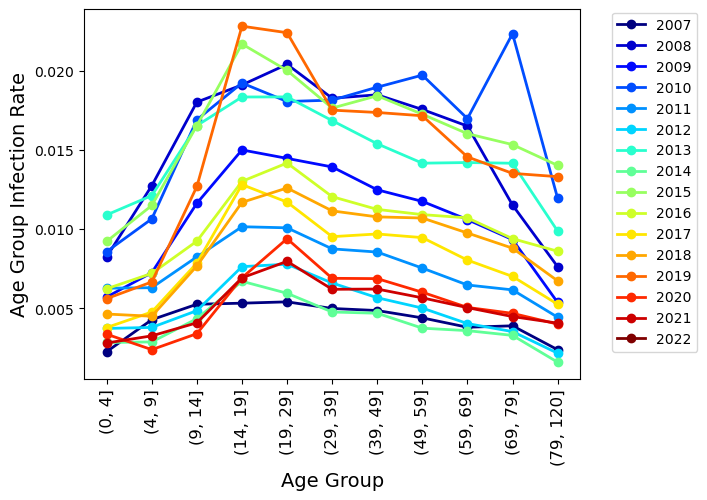

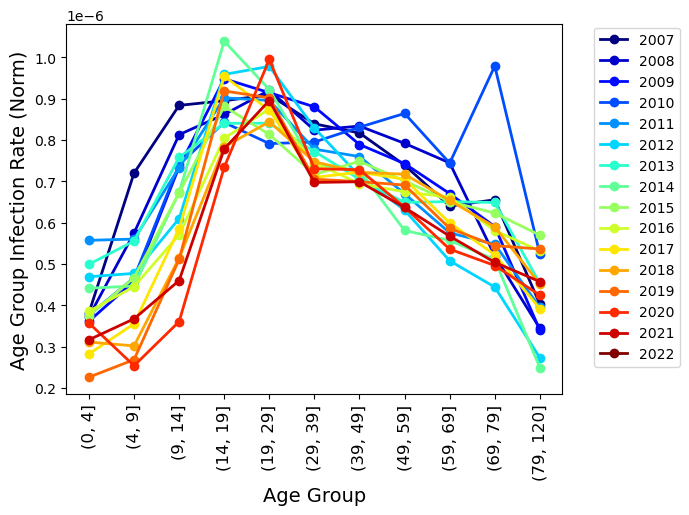

In [11]:
id_municipality = 520870
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 4: Brasilia, DF - serotypes

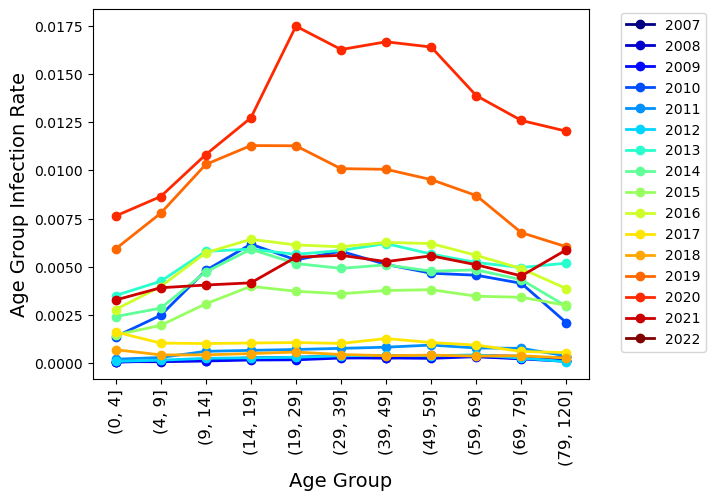

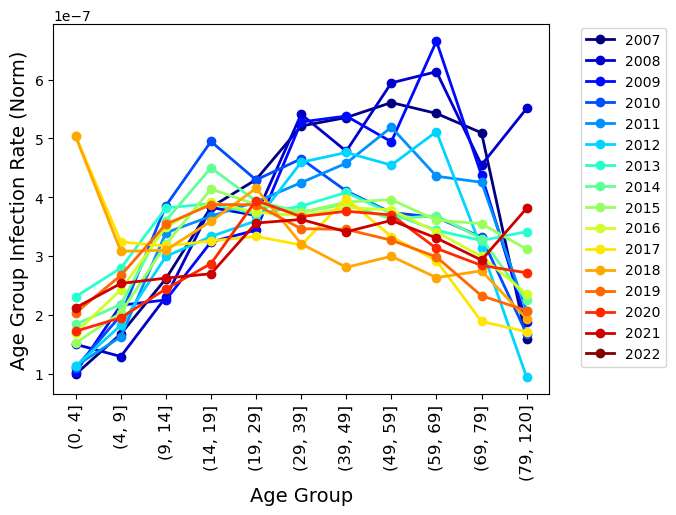

In [12]:
id_municipality = 530010
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 5: Fortaleza, CE - serotypes

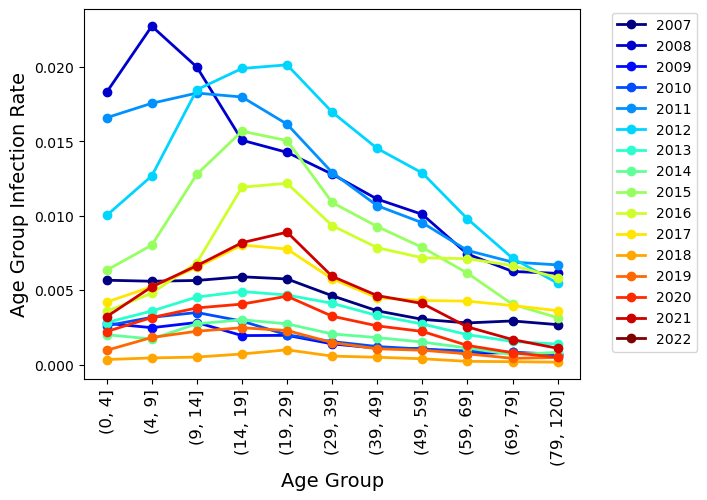

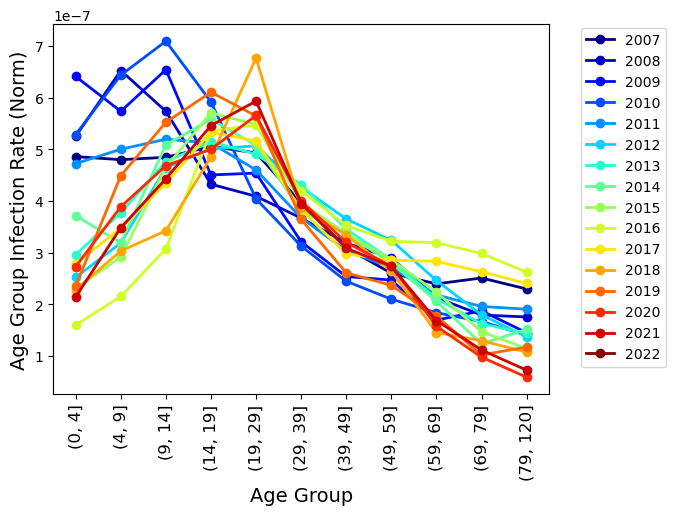

In [13]:
id_municipality = 230440
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 6: Belo Horizonte, MG - serotypes

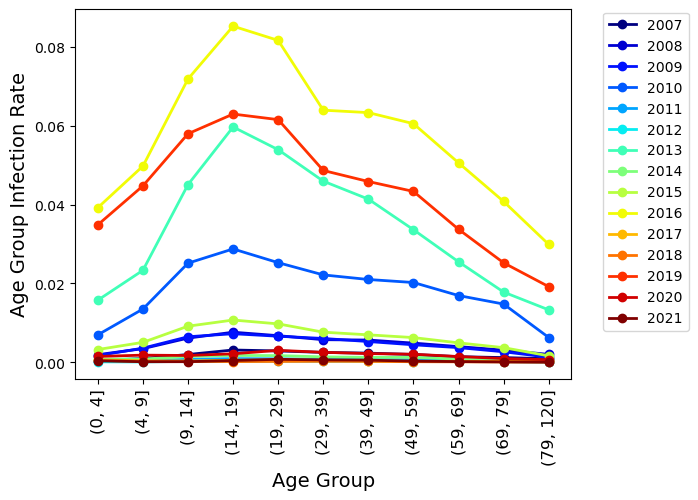

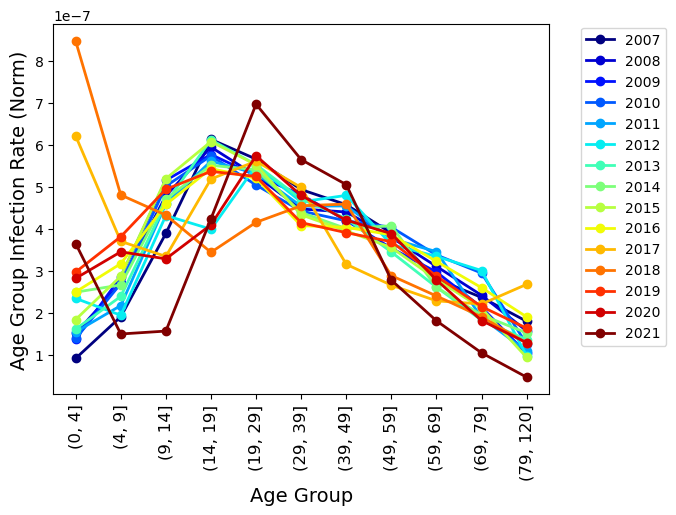

In [14]:
id_municipality = 310620
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 7: Riberao Preto, SP - serotypes

C:\Users\denise.cammarota\AppData\Local\Temp\ipykernel_12680\328714551.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sp_age_counts = sp_age_counts.append({'NU_ANO':year, 'age_range':age, 'CASES':0}, ignore_index=True)


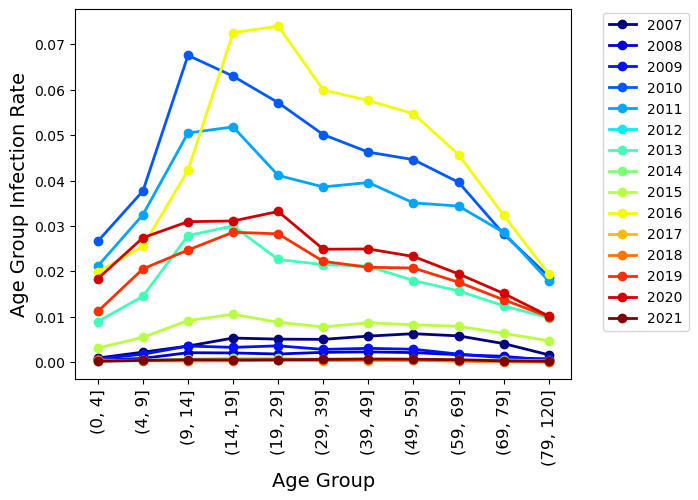

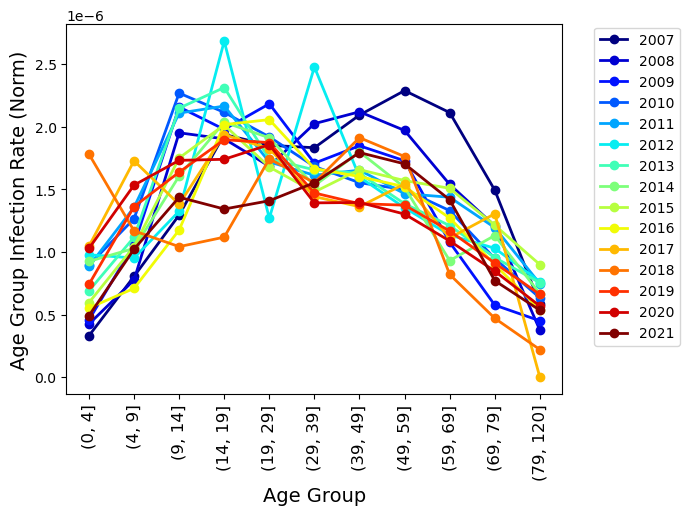

In [15]:
id_municipality = 354340
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

### Municipality 8: Sao José do Rio Preto - serotypes

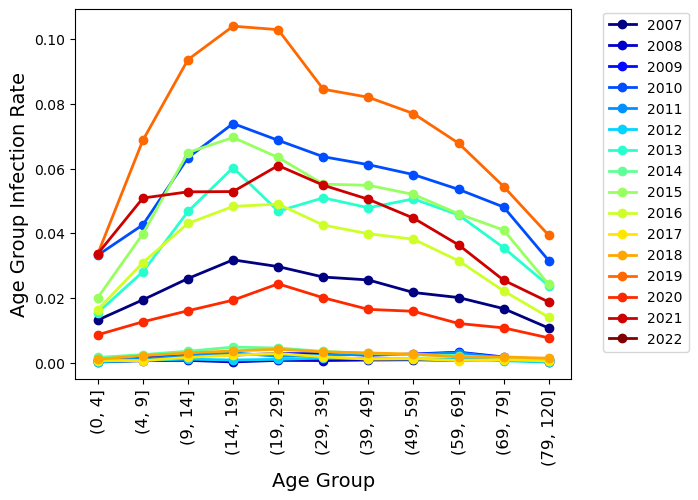

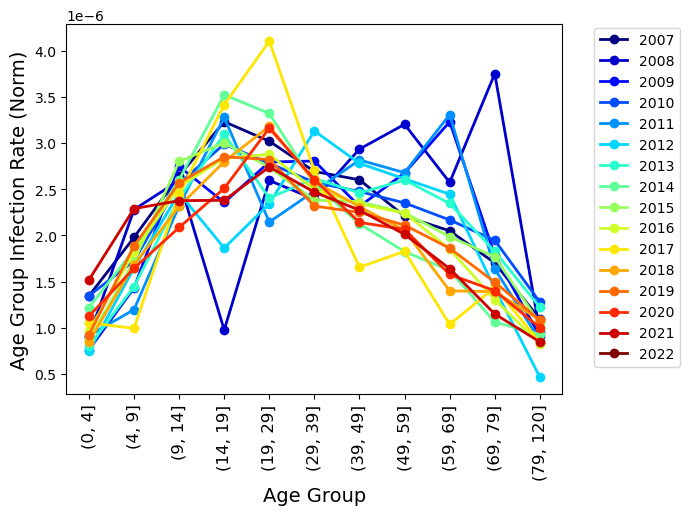

In [16]:
id_municipality = 354980
sp_age_mean, sp_age_counts = age_rates_municipality(id_municipality)
plot_age_rate(sp_age_counts)

In [17]:
sp_age_counts

,NU_ANO,age_range,CASES,CASES/POP,CASES/YEAR
0,2007,"(0, 4]",344,0.013230,9840.0
1,2007,"(4, 9]",520,0.019472,9840.0
2,2007,"(9, 14]",736,0.026048,9840.0
3,2007,"(14, 19]",1001,0.031806,9840.0
4,2007,"(19, 29]",2162,0.029724,9840.0
...,...,...,...,...,...
164,2021,"(79, 120]",272,0.018788,22219.0
165,2022,"(4, 9]",1,NaN,5.0
166,2022,"(9, 14]",1,NaN,5.0
167,2022,"(19, 29]",2,NaN,5.0


#### Looping for municipalities and calculating the normalized mean (some extra calculations I did before, probably wrong )

In [48]:
df_total = pd.DataFrame()
for id_municipality in municipalities:
    # opening datasus tabnet file 
    file_sus = '../Data/Data_PopMun/TABNET/pop_pyramid_'+str(id_municipality)+'.csv'
    sus_data = pd.read_csv(file_sus, delimiter = ';')
    sus_data = sus_data[:-1] # original data
    sus_data_props = sus_data.copy() # proportion of each group/total population by year
    sus_data_tmp = sus_data_props.iloc[:,1:]
    sus_data_tmp = sus_data_tmp.div(sus_data_tmp.sum(axis=0),axis=1) 
    sus_data_props.iloc[:,1:] = sus_data_tmp
    sus_props_stacked = sus_data_props.drop(columns = ['Faixa Etaria 1'])
    sus_props_stacked = sus_props_stacked.stack().reset_index(name = 'PROPS')
    sus_props_stacked = sus_props_stacked.sort_values(['level_1','level_0'])
    sus_props_stacked = sus_props_stacked.reset_index()
    sus_props_stacked = sus_props_stacked.drop(21) # no data for 2008 last age group of infected
    # now we stack the total 
    total_pop = sus_data.copy()
    total_pop = total_pop.drop(columns = ['Faixa Etaria 1'])
    total_pop = total_pop.sum(axis = 0)
    total_pop = total_pop.to_frame(name = 'POP').reset_index()
    # filtering for the municipality we are working with
    sp_age_data = age_data[age_data['ID_MUNICIP'] == id_municipality] 
    # mean age of infection (without population structure)
    sp_age_mean = sp_age_data.copy()
    sp_age_mean = sp_age_mean.groupby(['NU_ANO'])['NU_IDADE_N'].mean()
    sp_age_mean = sp_age_mean.to_frame(name = 'MEAN AGE').reset_index()
    sp_age_mean = sp_age_mean[~sp_age_mean['NU_ANO'].isin([2022])]
    # standarized age of infection
    years = sp_age_data['NU_ANO']
    sp_age_data['NU_IDADE_N'] = sp_age_data['NU_IDADE_N'].astype(float)
    # infected number per year
    sp_cases_data = sp_age_data.copy()
    sp_cases_data = sp_cases_data.groupby(['NU_ANO'])['NU_IDADE_N'].count()
    sp_cases_data = sp_cases_data.to_frame(name = 'CASES').reset_index() #here is the error
    sp_props_data = sp_cases_data.copy()
    sp_props_data['PROPS'] = sp_props_data['CASES']/total_pop['POP']
    # ages per age group and year of infected people
    sp_ages = sp_age_data.copy()
    sp_ages = sp_ages.groupby(['NU_ANO','age_range'])['NU_IDADE_N'].sum()
    sp_ages = sp_ages.to_frame().reset_index()
    sp_ages['extra_sort'] = sp_ages['age_range'].apply(lambda st: st[st.find("(")+1:st.find(",")])
    sp_ages['extra_sort'] = sp_ages['extra_sort'].astype(int)
    sp_ages = sp_ages.sort_values(by = ['NU_ANO','extra_sort'])
    sp_ages = sp_ages.reset_index()
    sp_ages = sp_ages.drop(columns = ['index','extra_sort'])
    res = sp_ages['NU_IDADE_N']*sus_props_stacked['PROPS']
    res = res[:-1]
    df_res = sp_ages.copy()
    df_res['age_rate'] = res
    list_tmp = []
    for i in df_res['NU_ANO']:
        list_tmp.append(float(sp_props_data[sp_props_data['NU_ANO'] == i]['PROPS']))
    df_res['tmp_mult'] = list_tmp
    df_res['age_rate'] = df_res['age_rate']*df_res['tmp_mult']
    df_res_2 = df_res.groupby(['NU_ANO'])['age_rate'].sum()
    df_res_2 = df_res_2.to_frame(name = 'MEAN AGE').reset_index()

C:\Users\denise.cammarota\AppData\Local\Temp\ipykernel_9024\1837818821.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_age_data['NU_IDADE_N'] = sp_age_data['NU_IDADE_N'].astype(float)


In [60]:
sp_age_data

,NU_IDADE_N,SOROTIPO,NU_ANO,ID_MUNICIP,age_range
229,61.0,,2007,355030,"(59, 69]"
242,69.0,,2007,355030,"(59, 69]"
243,31.0,,2007,355030,"(29, 39]"
244,28.0,,2007,355030,"(19, 29]"
251,28.0,1,2007,355030,"(19, 29]"
...,...,...,...,...,...
9944558,35.0,,2021,355030,"(29, 39]"
9944630,28.0,,2021,355030,"(19, 29]"
9944643,7.0,,2021,355030,"(4, 9]"
9944918,50.0,,2021,355030,"(49, 59]"
